In [239]:
import numpy as np
import legacyMTT
import matplotlib.pyplot as plt

import torch
import torch.distributions as dist
from deepMTT import NeuralNetwork

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from simulate.simulate_camera import get_camera_image 
from simulate.simulate_camera import add_molecule

In [5]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
%matplotlib inline

In [89]:
device = 'cpu'

model = NeuralNetwork().to(device)

In [172]:
learning_rate = 1e-1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [91]:
loss_fn = torch.nn.MSELoss()

In [177]:
mols_per_image=300
m_phot=256

for t in range(1000):
    n_pix = 2000
    X = get_camera_image(n_pix)
    for i in range(mols_per_image): 
        X, molecule_list = add_molecule(X, mean_num_photons=m_phot)
    alpha_est = model(X)
    m0, alpha, w_map = legacyMTT.wilks_map(X.view(n_pix, -1).detach().numpy(), 1, 7) 
    loss = loss_fn(alpha_est, torch.from_numpy(alpha).view(1,1,n_pix,-1).type(torch.float))
    if t % 100 == 0:
        print(t, loss.item())
    if t % 1000 == 0:
        print(t, model.shallow_cnn[0].weight)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 342723616.0
0 Parameter containing:
tensor([[[[-0.1864, -0.1290, -0.1573, -0.4437, -0.1993, -0.1808, -0.2418],
          [-0.1420, -0.0851, -0.0955, -0.2747, -0.1327, -0.1069, -0.1486],
          [-0.1810, -0.1085, -0.1441, -0.3334, -0.1584, -0.1047, -0.1764],
          [-0.4803, -0.2741, -0.3273, -0.4496, -0.2435, -0.2197, -0.4505],
          [-0.2175, -0.1097, -0.1394, -0.2426,  0.0245, -0.0078, -0.1751],
          [-0.1693, -0.0941, -0.1001, -0.2167, -0.0051, -0.0299, -0.1409],
          [-0.2399, -0.1533, -0.1687, -0.4478, -0.1884, -0.1598, -0.2218]]]],
       requires_grad=True)
100 10336419.0
200 10299457.0
300 10295519.0
400 10310725.0
500 10364556.0
600 10279583.0
700 10263494.0
800 10320996.0
900 10315825.0


In [178]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

shallow_cnn.0.weight tensor([[[[-0.2766, -0.2668, -0.2823, -0.3107, -0.2824, -0.2669, -0.2766],
          [-0.2670, -0.2514, -0.2655, -0.2930, -0.2656, -0.2515, -0.2669],
          [-0.2824, -0.2654, -0.2796, -0.3070, -0.2796, -0.2655, -0.2823],
          [-0.3109, -0.2931, -0.3072, -0.3345, -0.3072, -0.2931, -0.3108],
          [-0.2824, -0.2655, -0.2796, -0.3070, -0.2796, -0.2655, -0.2823],
          [-0.2670, -0.2515, -0.2656, -0.2930, -0.2655, -0.2514, -0.2669],
          [-0.2767, -0.2669, -0.2824, -0.3107, -0.2823, -0.2668, -0.2766]]]])
shallow_cnn.0.bias tensor([-348.0808])


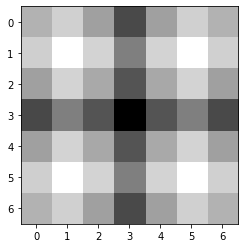

In [179]:
filt = model.shallow_cnn[0].weight.detach().view(7,-1).numpy()
plt.imshow(filt, cmap='gray')

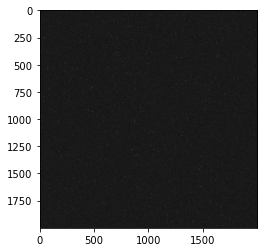

In [180]:
plt.imshow(alpha, cmap='gray')

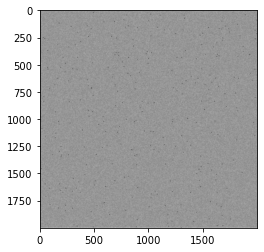

In [181]:
plt.imshow(alpha_est.detach().view(n_pix,-1), cmap='gray')

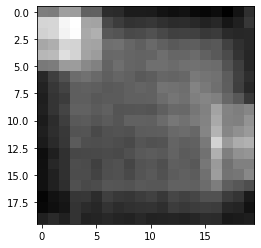

In [176]:
plt.imshow(alpha-alpha_est.detach().view(n_pix,-1).numpy(), cmap='gray')

In [182]:
loss = loss_fn(alpha_est, torch.from_numpy(alpha).view(1,1,n_pix,-1).type(torch.float))

In [183]:
loss.item()

10275298.0

In [184]:
loss = loss_fn(X, torch.from_numpy(alpha).view(1,1,n_pix,-1).type(torch.float))

In [185]:
loss.item()

3859170304.0

In [186]:
model2 = NeuralNetwork().to(device)

In [187]:
model2.shallow_cnn[0].weight = torch.nn.parameter.Parameter(torch.zeros((1,1,7,7)))

In [209]:
model2.shallow_cnn[0].weight = torch.nn.parameter.Parameter(torch.tensor([[[[0, 0, 0, 0, 0, 0, 0],\
                                                                           [0, 0, 0, 0, 0, 0, 0],\
                                                                           [0, 0, 0.5, 0.5, 0.5, 0, 0],\
                                                                           [0, 0, 0.5, 1., 0.5, 0, 0],\
                                                                           [0, 0, 0.5, 0.5, 0.5, 0, 0],\
                                                                           [0, 0, 0, 0, 0, 0, 0],\
                                                                           [0, 0, 0, 0, 0, 0, 0]]]]))

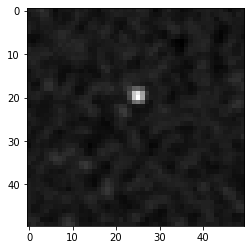

In [210]:
plt.imshow(model2(X).squeeze().detach()[100:150,150:200], cmap='gray')

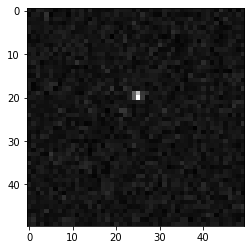

In [211]:
plt.imshow(X.squeeze().detach()[100:150,150:200], cmap='gray')

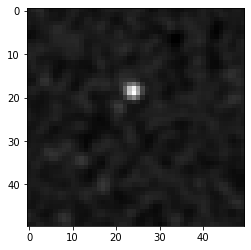

In [212]:
plt.imshow(alpha.squeeze()[100:150,150:200], cmap='gray')

In [213]:
loss = loss_fn(model2(X), torch.from_numpy(alpha).view(1,1,n_pix,-1).type(torch.float))

In [214]:
loss.item()

6223260672.0

In [215]:
loss = loss_fn(model(X), torch.from_numpy(alpha).view(1,1,n_pix,-1).type(torch.float))

In [216]:
loss.item()

10275298.0

In [217]:
print(model(X))

tensor([[[[-17264.7773, -22121.1133, -26749.7832,  ..., -28085.7051,
           -23290.9980, -18682.6602],
          [-23400.1133, -29431.1641, -35363.9219,  ..., -36350.4531,
           -30318.2383, -24405.6074],
          [-27741.5430, -34767.9727, -41817.6641,  ..., -41743.8398,
           -34947.1914, -28003.7734],
          ...,
          [-30238.6133, -38080.6992, -44041.2617,  ..., -43422.4844,
           -35250.5352, -27482.1777],
          [-25785.0996, -32704.6953, -37730.1094,  ..., -35548.9648,
           -28775.4004, -22104.3887],
          [-20545.3730, -26135.6191, -30060.1543,  ..., -28279.0566,
           -23193.6387, -18184.2207]]]], grad_fn=<MkldnnConvolutionBackward>)


In [218]:
print(model2(X))

tensor([[[[ 9273.9531, 13377.8857, 14331.5410,  ..., 12767.3936,
           12146.5410,  9978.6758],
          [12508.1602, 18080.6445, 19083.8242,  ..., 19920.9395,
           20370.6172, 14696.6553],
          [12721.1543, 17660.1660, 17575.4707,  ..., 20932.7402,
           21688.1855, 15023.5166],
          ...,
          [16380.9951, 23476.2715, 22883.7266,  ..., 18878.2109,
           19827.1602, 14198.5430],
          [16423.0684, 23294.2773, 23359.2266,  ..., 16923.6875,
           18845.8867, 14550.9727],
          [10131.6191, 15592.9414, 15640.9414,  ..., 10780.3584,
           13919.2109, 11236.8154]]]], grad_fn=<MkldnnConvolutionBackward>)


In [219]:
print(alpha)

[[-57920.00247681 -57920.01619604 -57920.0042721  ... -57919.97840485
  -57919.98805153 -57920.00855839]
 [-57920.02534468 -57920.03354284 -57920.00460567 ... -57919.92944229
  -57919.9692155  -57920.01503348]
 [-57919.97546337 -57919.9532832  -57919.91097546 ... -57919.92073861
  -57919.95671561 -57919.98074058]
 ...
 [-57919.86713268 -57919.87967425 -57919.90666272 ... -57920.00995202
  -57919.92774851 -57919.87976341]
 [-57919.92000496 -57919.89894319 -57919.87587026 ... -57920.03481319
  -57919.95939203 -57919.93756596]
 [-57919.96551177 -57919.94806633 -57919.91549561 ... -57920.03719917
  -57919.99678645 -57919.98866001]]


In [224]:
np.max(alpha[:])

-57917.572396317424

In [251]:
mols_per_image=1000
m_phot=64

learning_rate = 1e-3
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

for t in range(500):
    n_pix = 2000
    X = get_camera_image(n_pix)
    for i in range(mols_per_image): 
        X, molecule_list = add_molecule(X, mean_num_photons=m_phot)
    alpha_est = model2(X)
    m0, alpha, w_map = legacyMTT.wilks_map(X.view(n_pix, -1).detach().numpy(), 1, 7) 
    loss = loss_fn(alpha_est, torch.from_numpy(alpha).view(1,1,n_pix,-1).type(torch.float))
    if t % 10 == 0:
        print(t, loss.item())
    if t % 10 == 0:
        print(t, model2.shallow_cnn[0].weight)
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()

0 706348.0625
0 Parameter containing:
tensor([[[[ 0.0049,  0.0037,  0.0016, -0.0023, -0.0032, -0.0034, -0.0039],
          [ 0.0037, -0.0777, -0.0851, -0.0897, -0.0817, -0.0783, -0.0887],
          [ 0.0017, -0.0851, -0.0720, -0.0303,  0.0148, -0.0309, -0.0858],
          [-0.0022, -0.0897, -0.0304,  0.1458,  0.1734,  0.1133, -0.0393],
          [-0.0032, -0.0817,  0.0147,  0.1734,  0.2780,  0.1875,  0.0040],
          [-0.0034, -0.0783, -0.0310,  0.1133,  0.1875,  0.1410, -0.0409],
          [-0.0039, -0.0887, -0.0857, -0.0392,  0.0041, -0.0409, -0.0901]]]],
       requires_grad=True)
10 676522.75
10 Parameter containing:
tensor([[[[ 0.0057,  0.0046,  0.0024, -0.0015, -0.0044, -0.0046, -0.0031],
          [ 0.0045, -0.0797, -0.0867, -0.0911, -0.0835, -0.0805, -0.0905],
          [ 0.0025, -0.0867, -0.0737, -0.0319,  0.0129, -0.0326, -0.0871],
          [-0.0014, -0.0911, -0.0320,  0.1483,  0.1812,  0.1173, -0.0407],
          [-0.0044, -0.0835,  0.0128,  0.1813,  0.2874,  0.1951,  0.0

130 419912.6875
130 Parameter containing:
tensor([[[[-0.0022, -0.0025, -0.0057, -0.0108, -0.0142, -0.0139, -0.0122],
          [-0.0025, -0.0982, -0.1011, -0.1026, -0.1018, -0.1040, -0.1083],
          [-0.0057, -0.1011, -0.0911, -0.0475, -0.0089, -0.0503, -0.0998],
          [-0.0108, -0.1026, -0.0476,  0.1633,  0.2712,  0.1553, -0.0557],
          [-0.0142, -0.1018, -0.0089,  0.2712,  0.3951,  0.2811, -0.0175],
          [-0.0139, -0.1040, -0.0503,  0.1553,  0.2811,  0.1569, -0.0588],
          [-0.0123, -0.1082, -0.0998, -0.0556, -0.0174, -0.0587, -0.1072]]]],
       requires_grad=True)
140 408178.125
140 Parameter containing:
tensor([[[[-0.0025, -0.0028, -0.0061, -0.0113, -0.0148, -0.0145, -0.0128],
          [-0.0028, -0.0989, -0.1017, -0.1032, -0.1027, -0.1051, -0.1091],
          [-0.0061, -0.1017, -0.0919, -0.0483, -0.0101, -0.0513, -0.1005],
          [-0.0113, -0.1033, -0.0484,  0.1631,  0.2768,  0.1562, -0.0567],
          [-0.0149, -0.1027, -0.0101,  0.2768,  0.4031,  0.286

270 338291.78125
270 Parameter containing:
tensor([[[[-0.0056, -0.0060, -0.0098, -0.0160, -0.0202, -0.0196, -0.0175],
          [-0.0060, -0.1033, -0.1060, -0.1082, -0.1089, -0.1116, -0.1147],
          [-0.0098, -0.1061, -0.0970, -0.0546, -0.0181, -0.0582, -0.1062],
          [-0.0160, -0.1082, -0.0545,  0.1571,  0.3204,  0.1536, -0.0639],
          [-0.0202, -0.1090, -0.0181,  0.3204,  0.4916,  0.3223, -0.0275],
          [-0.0195, -0.1116, -0.0581,  0.1536,  0.3223,  0.1498, -0.0674],
          [-0.0175, -0.1147, -0.1062, -0.0639, -0.0275, -0.0675, -0.1151]]]],
       requires_grad=True)
280 334516.5
280 Parameter containing:
tensor([[[[-0.0058, -0.0062, -0.0100, -0.0162, -0.0204, -0.0198, -0.0177],
          [-0.0061, -0.1035, -0.1062, -0.1084, -0.1091, -0.1119, -0.1149],
          [-0.0100, -0.1063, -0.0972, -0.0549, -0.0184, -0.0584, -0.1065],
          [-0.0162, -0.1084, -0.0548,  0.1567,  0.3219,  0.1533, -0.0642],
          [-0.0204, -0.1092, -0.0184,  0.3219,  0.4972,  0.3233

410 315568.625
410 Parameter containing:
tensor([[[[-0.0070, -0.0074, -0.0114, -0.0178, -0.0223, -0.0215, -0.0193],
          [-0.0073, -0.1047, -0.1076, -0.1100, -0.1111, -0.1136, -0.1165],
          [-0.0114, -0.1076, -0.0988, -0.0567, -0.0207, -0.0604, -0.1082],
          [-0.0178, -0.1100, -0.0567,  0.1540,  0.3301,  0.1504, -0.0662],
          [-0.0223, -0.1111, -0.0207,  0.3300,  0.5558,  0.3273, -0.0303],
          [-0.0214, -0.1137, -0.0604,  0.1503,  0.3273,  0.1466, -0.0700],
          [-0.0194, -0.1166, -0.1083, -0.0663, -0.0304, -0.0701, -0.1175]]]],
       requires_grad=True)
420 314202.78125
420 Parameter containing:
tensor([[[[-0.0071, -0.0074, -0.0114, -0.0179, -0.0224, -0.0215, -0.0194],
          [-0.0074, -0.1048, -0.1077, -0.1101, -0.1112, -0.1137, -0.1166],
          [-0.0114, -0.1077, -0.0989, -0.0568, -0.0208, -0.0605, -0.1083],
          [-0.0179, -0.1101, -0.0568,  0.1539,  0.3302,  0.1503, -0.0663],
          [-0.0223, -0.1112, -0.0208,  0.3301,  0.5592,  0.32

In [245]:
loss = loss_fn(alpha_est, torch.from_numpy(alpha).view(1,1,n_pix,-1).type(torch.float))
loss.item()

1625126.375

In [246]:
loss = loss_fn(model(X), torch.from_numpy(alpha).view(1,1,n_pix,-1).type(torch.float))
loss.item()

3347095552.0

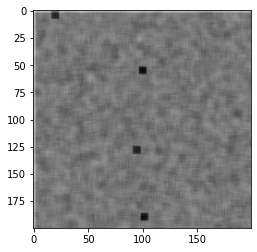

In [247]:
plt.imshow(model(X).detach().squeeze()[0:200,0:200],cmap='gray')

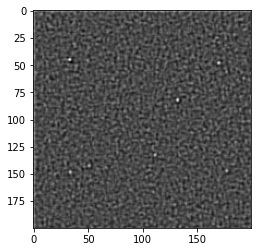

In [253]:
plt.imshow(model2(X).detach().squeeze()[0:200,0:200],cmap='gray')

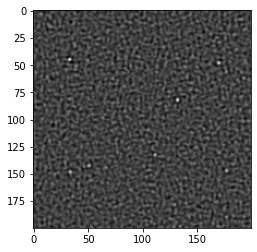

In [254]:
plt.imshow(alpha[0:200,0:200],cmap='gray')

In [240]:
m0, alpha, w_map = legacyMTT.wilks_map(X.view(n_pix, -1).detach().numpy(), 1, 7) 

In [241]:
alpha

array([[ 1299.39018779,  -416.91856278, -1733.42312156, ...,
         -537.54341455,   601.82444485,  1096.30984566],
       [ 1380.92868581,   581.65373018,    96.72186026, ...,
        -1674.90147645,  -912.78264551,   343.77281994],
       [ 1202.32285038,   643.51613897,    49.90619632, ...,
        -1453.68955006,  -771.35439541,   803.77569762],
       ...,
       [ 1441.2191175 ,  1929.05568659,   303.5110056 , ...,
         1153.1119584 ,   147.9637679 ,  -374.26454804],
       [ 1764.01813945,   782.58564655, -1416.11366951, ...,
         1000.51487192,   496.79769376,   480.937961  ],
       [ 2462.59688474,   227.78254069, -2367.37056979, ...,
          119.64878712,   810.81003056,  1711.16948463]])

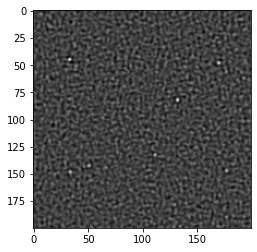

In [252]:
plt.imshow(alpha[0:200,0:200], cmap='gray')

In [255]:
print('yolo')

yolo
